# 10. Численные методы

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Задача:** построить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Преобразование-названий-признаков" data-toc-modified-id="Преобразование-названий-признаков-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span><strong>Преобразование названий признаков</strong></a></span></li><li><span><a href="#Удаление-лишних-признаков" data-toc-modified-id="Удаление-лишних-признаков-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span><strong>Удаление лишних признаков</strong></a></span></li><li><span><a href="#Обработка-пропущенных-значений" data-toc-modified-id="Обработка-пропущенных-значений-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span><strong>Обработка пропущенных значений</strong></a></span></li><li><span><a href="#Поиск-и-исправление-ошибочных-значений" data-toc-modified-id="Поиск-и-исправление-ошибочных-значений-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span><strong>Поиск и исправление ошибочных значений</strong></a></span></li><li><span><a href="#Преобразование-типов-данных" data-toc-modified-id="Преобразование-типов-данных-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Преобразование типов данных</a></span></li><li><span><a href="#Проверка-дубликатов" data-toc-modified-id="Проверка-дубликатов-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>Проверка дубликатов</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></div>

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

Загрузим данные и посмотрим, что они из себя представляют.

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Исследуемый датафрейм содержит следующую информацию:


**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


**Вывод**

Видим, что датафрейм содержит 354369 объектов и 16 признаков, присутствуют и пропуски, и явные ошибки среди значений некоторых признаков.

**Необходима предобработка данных:**

1. Названия признаков, состоящих из нескольких слов, разделить символом `_`. После этого преобразовать названия всех признаков в нижний регистр.
2. Очистить датафрейм от избыточной информации (убрать лишние признаки, осложняющие процесс построения моделей машинного обучения).
3. Произвести обработку пропущенных значений.
4. Выяснить природу возникновения нулевых значений в столбцах `Price`, `Power`, `RegistrationMonth` и `NumberOfPictures`.
5. При необходимости выполнить преобразование типов данных.
6. Проверить наличие дубликатов в данных.

### Подготовка данных

Выполним преобразования согласно ранее намеченному плану.

#### **Преобразование названий признаков**

Названия признаков выглядят следующим образом:

In [6]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Выполним преобразования, используя регулярное выражение.

In [7]:
list1 = []
for name in list(df.columns):
    name = re.findall('[A-Z]+[a-z]*', name)
    word1 = ''
    for word in name:
        word1 += word + '_'
    word1 = str(word1).lower().strip('_')
    list1.append(word1)
df.columns = list1

Как результат, получили корректные названия столбцов:

In [8]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### **Удаление лишних признаков**

Признаки `date_crawled`, `date_created` и `last_seen` являются избыточными для наших будующих моделей, никакой пользы для предсказания цены автомобиля они не принесут, поэтому можем удалить их из датафрейма.

In [9]:
df = df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)

**Важное замечание:** признак `postal_code` также не является важным для построения моделей, но данный параметр служит своеобразным уникальным идентификатором объекта (мы допускаем, что разные люди могли выставлять анкеты одинаковых по параметрам автомобилей). С целью предотвращения удаления бОльшего количества дубликатов в одном из следующих шагов, на данном этапе оставим признак в выборке, но уберем его перед построением моделей.

Рассмотрим столбец `number_of_pictures`.

In [10]:
df['number_of_pictures'].value_counts(dropna=False)

0    354369
Name: number_of_pictures, dtype: int64

Видим, что для каждого объекта значение признака одинаково и равно нулю. По этой причине мы можем избавиться от этого столбца, смысловой нагрузки он не несет.

In [11]:
df = df.drop('number_of_pictures', axis=1)

Проверяем результаты выполненных действий.

In [12]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'postal_code'],
      dtype='object')

#### **Обработка пропущенных значений**

Посмотрим на количество пропусков в датафрейме. Для этого используем функцию **nan_percent**.

In [13]:
def nan_percent(data):
    new_data = data.isna().sum().to_frame()
    new_data = new_data.rename(columns = {0: 'missing_values'})
    new_data['% of total'] = ((new_data['missing_values'] / data.shape[0])*100).round(2)
    return new_data.sort_values(by = 'missing_values', ascending = False).head(10)

In [14]:
nan_percent(df)

,missing_values,% of total
not_repaired,71154,20.08
vehicle_type,37490,10.58
fuel_type,32895,9.28
gearbox,19833,5.60
model,19705,5.56
price,0,0.00
registration_year,0,0.00
power,0,0.00
kilometer,0,0.00
registration_month,0,0.00


Пропуски присутствуют среди объектов пяти признаков:
- `not_repaired`
- `vehicle_type`
- `fuel_type`
- `gearbox`
- `model`

Разберемся с каждым по очереди.

In [15]:
df['not_repaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: not_repaired, dtype: int64

Признак `not_repaired` содержит более 70 тысяч пропущенных значений, что составляет 20% от общего числа объектов - существенная часть, но не критическая. При удалении остается большое количество объектов для успешного обучения моделей. С другой стороны,  заполнение каким-либо из возможных значений приведет к потере точности модели и внесению дополнительных искажений. По этим причинам, на данном этапе самым верным решением будет удаление этих пропущенных значений, а не выделение их в отдельную категорию. Однако в будущем, возможно потребуется внести коррективы.

Рассмотрим признак `vehicle_type`

In [16]:
df['vehicle_type'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

У признака `vehicle_type` заметно меньше пропусков, поэтому можем также прибегнуть к удалению пропущенных объектов.

Для оставшихся признаков `fuel_type`, `gearbox` и `model` выполним аналогичные действия по удалению.

In [17]:
df['fuel_type'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [18]:
df['gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: gearbox, dtype: int64

In [19]:
df['model'].value_counts(dropna=False)

golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 251, dtype: int64

In [20]:
# удаляем пропуски
df.dropna(subset=['not_repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model'], inplace=True)

Выполним проверку: посчитаем количество пропусков в датафрейме `df` после произведенных замен.

In [21]:
df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
postal_code           0
dtype: int64

Пропущенные значения отсутствуют, значит преобразования выполнили корректно.

#### **Поиск и исправление ошибочных значений**

На первоначальном этапе знакомства с датафремом, были отмечены следующие моменты, требующие дополнительного изучения:

1. `registration_year` содержит значения далекие от реальных, а именно 1000-й и 9999-й значения годов регистрации авто.
2. У признака `registration_month` также есть нулевые значения. В этом случае либо закралась ошибка, либо у сервиса «Не бит, не крашен» свой календарь с 13-ю месяцами (нет).
3. Признак `price` содержит нулевые значения. Это выглядит странным. В каком бы плохом состоянии не был автомобиль, он должен иметь свою цену, отличную от нуля.
4. Среди значений мощности автомобилей `power` также есть нулевые. Требуется рассмотреть их подробнее и принять решение относительно их возможного удаления из рассматриваемой выборки.

Для построения графиков распределения и диаграмм размаха используем функцию **'show_info'**

In [22]:
def show_info(data, bins, range_min, range_max, title, xlabel, flag):
    plt.figure(figsize=(16, 5))
    plt.grid()
    plt.hist(data, range=(range_min, range_max), bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Количество объектов')
    plt.title(title)
    plt.show()
    if flag:
        plt.figure(figsize=(16, 5))
        plt.grid()
        plt.boxplot(data, labels=' ')
        plt.title(f'Диаграмма размаха')
        plt.ylabel(xlabel)
        plt.show()
        print('Среднее значение:', data.mean())
        print('Медиана:', data.median())

**Признак `registration_year`**

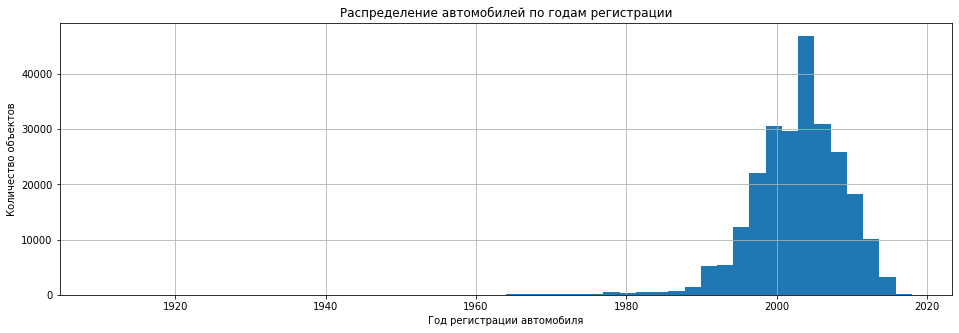

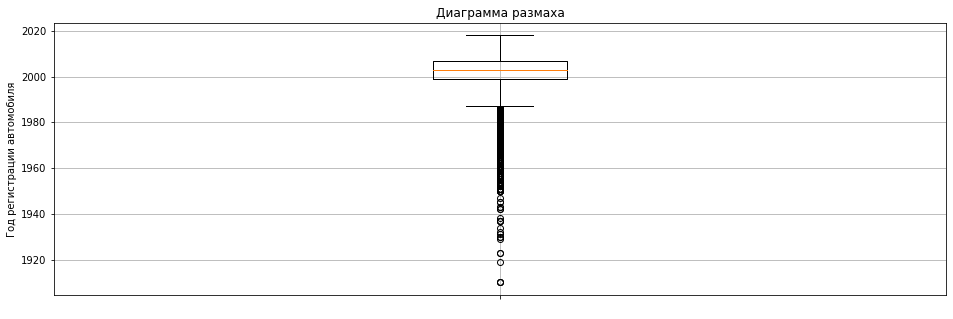

Среднее значение: 2002.91869869088
Медиана: 2003.0


In [23]:
show_info(df['registration_year'], 50, df['registration_year'].min(), df['registration_year'].max(), 'Распределение автомобилей по годам регистрации', 'Год регистрации автомобиля', 1)

Наблюдаем выбросы, которые необходимо убрать, а также значения годов, превышающие настоящий 2021-й год.

Объектов, год регистрации которых меньше 1960, почти нет, поэтому в выборке оставим автомобили, у которых `registration_year` лежит в дипазоне от 1960 до 2021 года.

In [25]:
df = df[(df['registration_year']<=2021)&(df['registration_year']>=1960)]

Посмотрим на распределение еще раз.

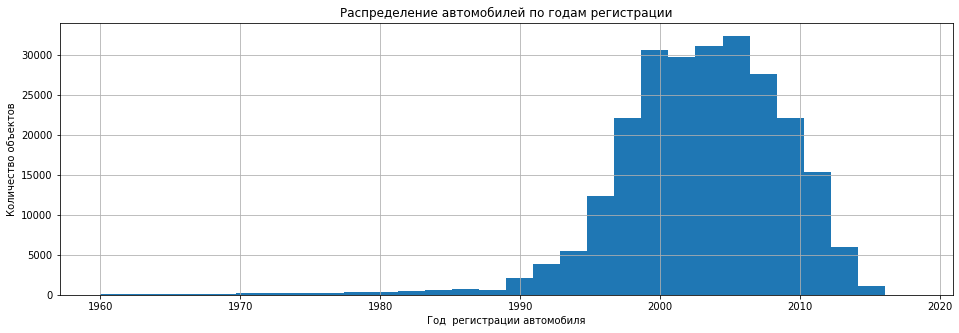

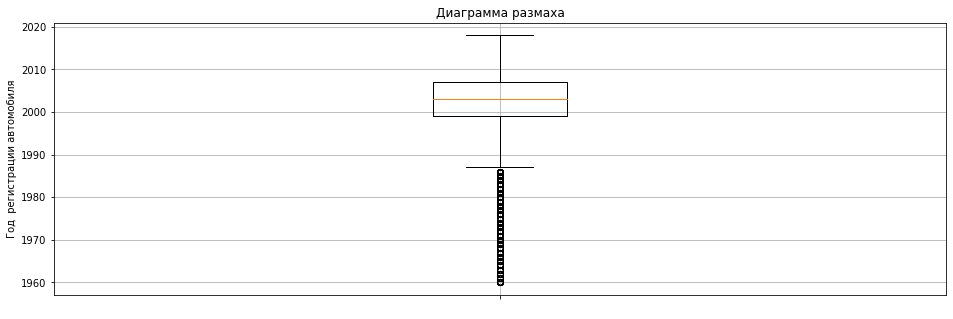

Среднее значение: 2002.937857866657
Медиана: 2003.0


In [26]:
show_info(df['registration_year'], 30, df['registration_year'].min(), df['registration_year'].max(), 'Распределение автомобилей по годам регистрации', 'Год  регистрации автомобиля', 1)

Результата достигли - избавились от явных выбросов. Остался длинный "левый хвост" (значения меньше 1990), но он несет полезную нагрузку, допускаем наличие в выборке автомобилей такого "возраста".

**Признак `registration_month`**

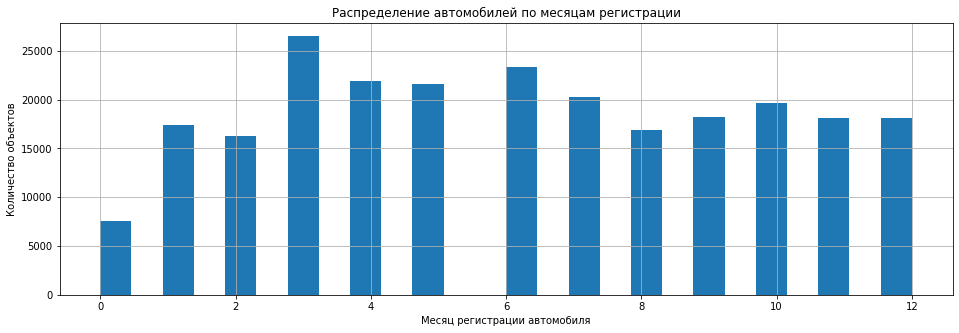

In [27]:
show_info(df['registration_month'], 26, df['registration_month'].min(), df['registration_month'].max(), 'Распределение автомобилей по месяцам регистрации', 'Месяц регистрации автомобиля', 0)

Появление месяца с номером '0', скорее всего связано с пропуском данного параметра при заполнении анкеты. Т.е. пользователь не указал месяц регистрации автомобиля (умышленно или по незнанию). С другой стороны, для построения моделей машинного обучения, наличие или отсутствие данного параметра не критично, если учитывать, что в нашем распоряжении есть год регистрации авто. Принимая это во внимание, удалим этот столбец из нашей выборки.

In [28]:
df = df.drop('registration_month', axis=1)

**Признак `price`**

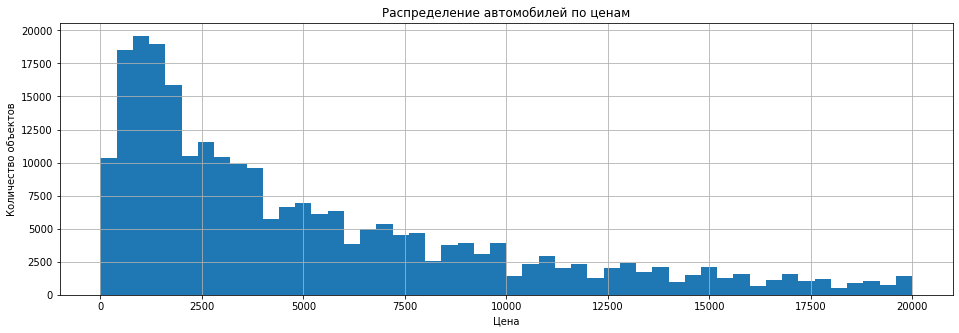

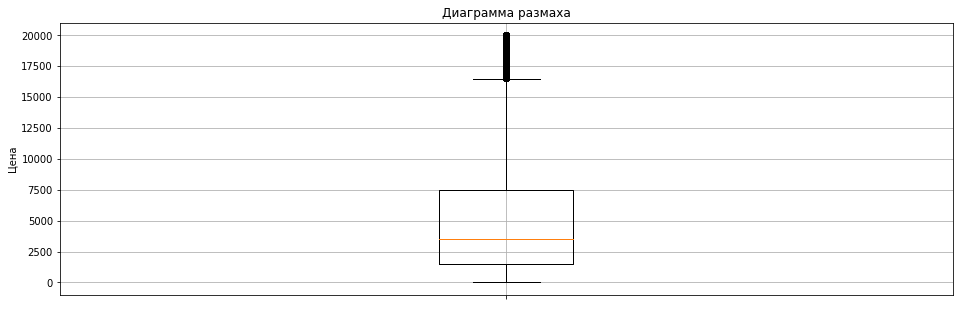

Среднее значение: 5124.214652846452
Медиана: 3500.0


In [29]:
show_info(df['price'], 50, df['price'].min(), df['price'].max(), 'Распределение автомобилей по ценам', 'Цена', 1)

Наблюдаем скошенность данных вправо - чем дороже автомобиль, тем меньше их количество в рассматриваемой выборке. 

Посмотрим на распределние вблизи нулевой цены.

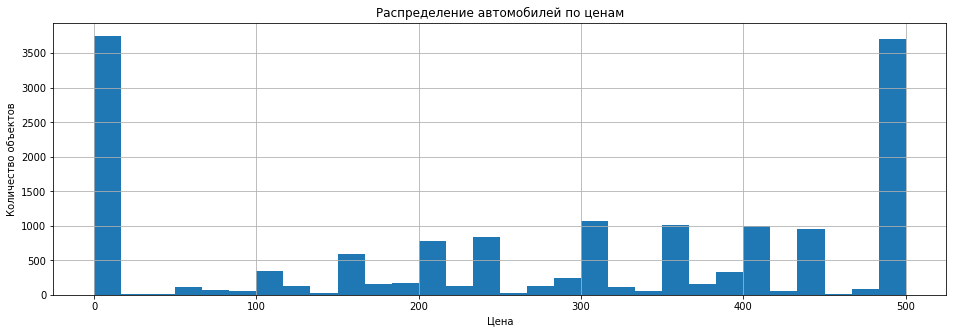

In [30]:
show_info(df['price'], 30, 0, 500, 'Распределение автомобилей по ценам', 'Цена', 0)

Наблюдаем более 3500 значений объектов с ценой равной 0. Заменить нулевые значению на какие-либо еще мы не можем, т.к. `price` - целевой признак, а любые вносимые коррективы скажутся на моделях. Необходимо отфильтровать такие значения. Условимся считать, что цена выставляемого на продажу автомобиля должна начинаться со 100 евро.

In [31]:
# смотрим, как много данных мы потеряем
(df.query('price<100').shape[0])/df.shape[0]

0.016318923032470994

При фильтрации по цене автомобиля более 100 евро, мы утрачиваем менее 2% данных.

In [32]:
# оставляем в выборке автомобили с ценой более 100 евро
df = df[df['price']>=100]

Рассмотрим распределение мощностей автомобилей (**признак `power`**)

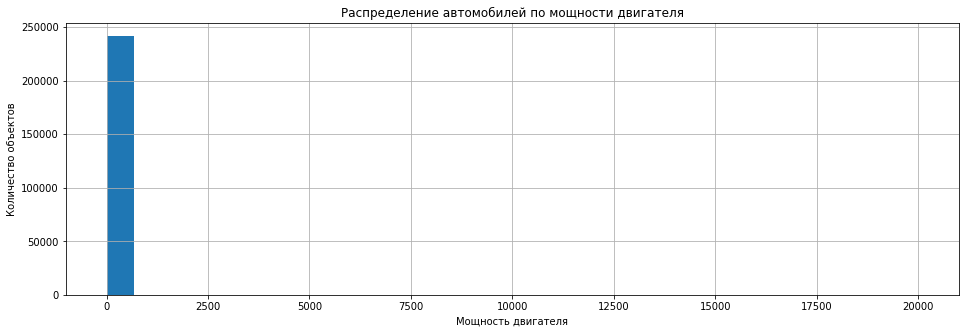

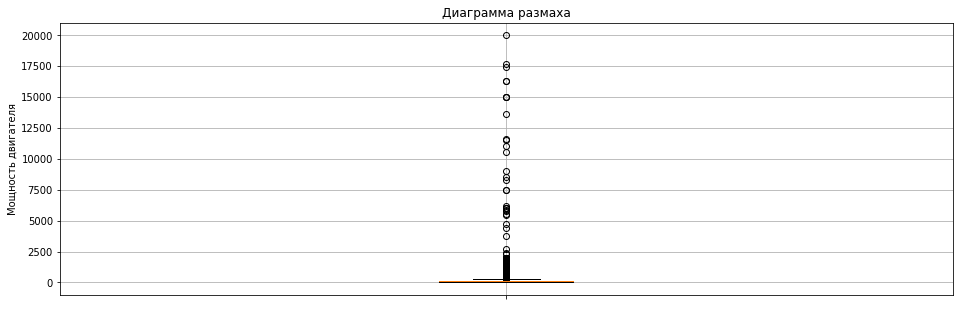

Среднее значение: 120.22204478791313
Медиана: 111.0


In [33]:
show_info(df['power'], 30, df['power'].min(), df['power'].max(), 'Распределение автомобилей по мощности двигателя', 'Мощность двигателя', 1)

В данном признаке присутствуют выбросы, которые необходимо убрать. Но сначала посмотрим на значения мощности, меньшие шестисот.

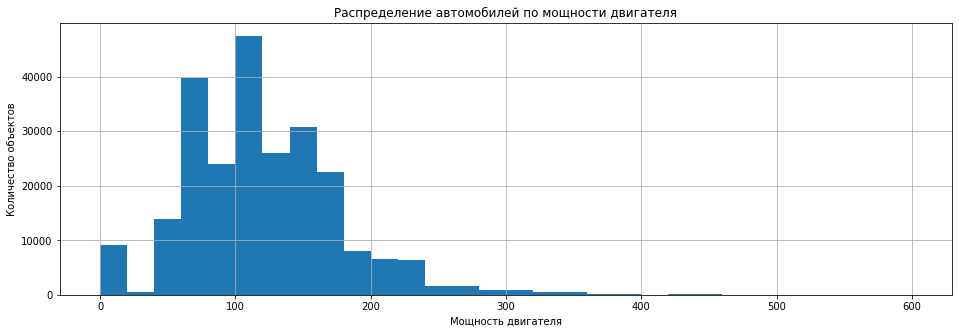

In [34]:
show_info(df['power'], 30, 0, 600, 'Распределение автомобилей по мощности двигателя', 'Мощность двигателя', 0)

Значений мощности больше 500 почти отсутствуют, это будет верхним пределом фильтрации. Другой проблемой являются нулевые значения. Посмотрим, что это за объекты.

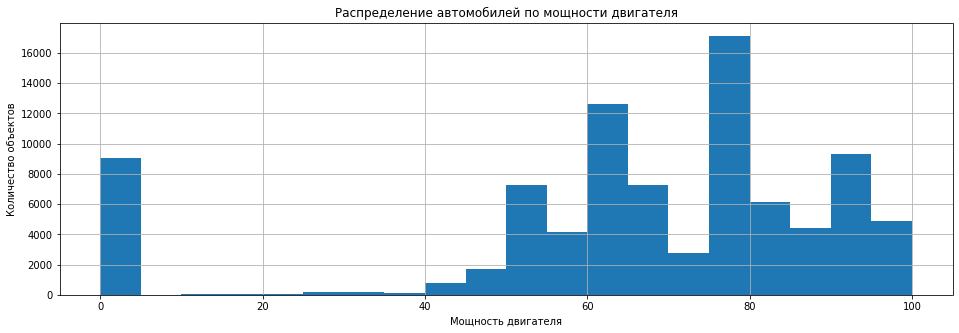

In [35]:
show_info(df['power'], 20, 0, 100, 'Распределение автомобилей по мощности двигателя', 'Мощность двигателя', 0)

Видим, что в исследуемой выборке около 9000 автомобилей, для которых значение мощности указано '0'. Можем часть из них заполнить. Для этого построим сводную таблицу, сгруппированную по признаку `model`, и найдем среднее значение мощности двигателя. После этого произведем замену нулевых значений.

In [36]:
# строим сводную таблицу
mean_power = df.groupby('model')['power'].mean().astype('int')
mean_power

model
100        133
145        103
147        153
156        145
159        170
          ... 
yaris       77
yeti       120
ypsilon     70
z_reihe    174
zafira     121
Name: power, Length: 249, dtype: int64

Используем функцию **add_power**, которая на вход получает строку таблицы и если в столбце 'power' стоит 0, то меняет его на среднее значение из соответствующей строки таблицы 'mean_power'

In [37]:
def add_power(row):
    model = row['model']
    power = row['power']
    if power == 0:
        return mean_power[model]
    else:
        return power

In [38]:
#Применяем функцию для каждой строки таблицы
df['power'] = df.apply(add_power, axis=1)

In [39]:
# Убираем оставшиеся нулевые значения в столбце 'power'
df = df.query('power!=0')

#### Преобразование типов данных

Посмотрим на типы данных признаков.

In [40]:
df.dtypes

price                 int64
vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer             int64
fuel_type            object
brand                object
not_repaired         object
postal_code           int64
dtype: object

У всех признаков корректные типы данных, поэтому преобразования выполнять не будем.

#### Проверка дубликатов

Проверим выборку на наличие дубликатов.

In [41]:
df.duplicated().sum()

18289

Дублирующих значений не очень много по сравнению с полным объемом выборки. Если их оставить, то больших искажений в результат работы моделей они не привнесут. Однако, для чистоты эксперименты, все же удалим их из выборки.

In [42]:
df.shape

(241717, 11)

In [43]:
df = df.drop_duplicates().reset_index(drop=True)

Как упоминалось в пункте 1.2.2, после удаления дуликатов требуется убрать из выборки признак `postal_code`. 

In [44]:
df = df.drop('postal_code', axis=1)

In [45]:
df.shape

(223428, 10)

**Вывод**

Подготовили данные для построения моделей:
- убрали из датасета лишние признаки;
- обработали пропущенные и аномальные (нулевые) значения;
- очистили выборку от дубликатов.

Своими преобразованиями нам удалось сохранить более 223 тысяч объектов.

## Обучение моделей

Перед построением моделей выделим целевой признак (`price`) и разделим выборку на обучающую и валидационную.

In [46]:
features = df.drop(['price'], axis=1)  
target = df['price'] 

In [47]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

Для построения некоторых моделей нам потребуются категориальные признаки отдельно.

In [48]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

В рамках исследования мы будет обучать 3 модели регрессии:
- LightGBM
- CatBoost
- RandomForest

Библиотека LightGBM требовательна к категориальным переменным, требуется их преобразование в тип данных 'category'.

In [49]:
features_train = features_train.astype({'vehicle_type':'category',
                                        'gearbox':'category',
                                        'model':'category',
                                        'fuel_type':'category',
                                        'brand':'category', 
                                        'not_repaired':'category'})

features_test = features_test.astype({'vehicle_type':'category',
                                        'gearbox':'category',
                                        'model':'category',
                                        'fuel_type':'category',
                                        'brand':'category', 
                                        'not_repaired':'category'})

**LightGBM**

In [50]:
%%time 

i = 0
best_result = 100000000
best_depth = 0
best_est = 0
light_df = pd.DataFrame(columns=['n_estimators','max_depth','RMSE'])
for depth in tqdm(range(4,6)):
    for est in range(400,501,100):
        model1 = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth, eval_metric='rmse', categorical_feature=cat_features)
        scores = cross_val_score(model1, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
        final_score = ((scores*(-1))**0.5).mean()
        light_df.loc[i] = np.array([est, depth, final_score])
        i += 1
        if final_score<best_result:
            best_light_model = model1
            best_result = final_score
            best_depth = depth
            best_est = est
print(f'RMSE наилучшей модели на валидационной выборке {best_result}')

100%|██████████| 2/2 [04:11<00:00, 125.58s/it]

RMSE наилучшей модели на валидационной выборке 1556.4041655354758
CPU times: user 4min 5s, sys: 1.14 s, total: 4min 6s
Wall time: 4min 11s


In [51]:
light_df.sort_values(by='RMSE').head()

,n_estimators,max_depth,RMSE
3,500.0,5.0,1556.404166
2,400.0,5.0,1561.026722
1,500.0,4.0,1573.710477
0,400.0,4.0,1581.008340


Обучили модели с различными значениями гиперпараметров. Заметим, что наилучшее (наименьшее) значение метрики **RMSE = 1556** достигнуто при параметрах `n_estimators = 500` и `max_depth = 5`, которые являются верхними пределами в заданных нами диапазонах. Можем предположить, что с увеличением значений параметров произойдет уменьшение метрики RMSE.

Проверим модель на тестовой выборке.

In [52]:
best_light_model.fit(features_train, target_train)
predicted_test1 = best_light_model.predict(features_test)
result = mean_squared_error(target_test, predicted_test1) ** 0.5
print(f'RMSE наилучшей модели на тестовой выборке: {result}')

RMSE наилучшей модели на тестовой выборке: 1547.1403881986757


Модель прошла проверку успешно: значение метрики **RMSE = 1547** на тестовой выборке лучше, чем на обучающей.

**CatBoost**

In [53]:
%%time

i = 0
best_result = 100000000
best_depth = 0
best_iter = 0
catboost_df = pd.DataFrame(columns=['iterations','max_depth','RMSE'])

for depth in tqdm(range(5,6)):
    for iteration in range(400,501,100):
        model2 = CatBoostRegressor(loss_function='MAE',
                                   eval_metric='RMSE',
                                   cat_features=cat_features,
                                   iterations=iteration,
                                   depth=depth,
                                   verbose=iteration)
        scores = cross_val_score(model2, features_train, target_train, cv=3, scoring='neg_mean_squared_error')
        final_score = ((scores*(-1))**0.5).mean()
        catboost_df.loc[i] = np.array([iteration, depth, final_score])
        i += 1
        if final_score<best_result:
            best_catboost_model = model2
            best_result = final_score
            best_depth = depth
            best_iter = iteration
print(f'RMSE наилучшей модели на валидационной выборке {best_result}')

  0%|          | 0/1 [00:00<?, ?it/s]

0:	learn: 4901.8827989	total: 172ms	remaining: 1m 8s
399:	learn: 1781.1867788	total: 1m 10s	remaining: 0us
0:	learn: 4893.5309905	total: 130ms	remaining: 52s
399:	learn: 1789.3974606	total: 1m 10s	remaining: 0us
0:	learn: 4914.0474734	total: 119ms	remaining: 47.5s
399:	learn: 1784.9963218	total: 1m 10s	remaining: 0us
0:	learn: 4901.8827989	total: 120ms	remaining: 59.7s
499:	learn: 1749.3687509	total: 1m 29s	remaining: 0us
0:	learn: 4893.5309905	total: 132ms	remaining: 1m 6s
499:	learn: 1759.0747444	total: 1m 28s	remaining: 0us
0:	learn: 4914.0474734	total: 197ms	remaining: 1m 38s
499:	learn: 1757.0145802	total: 1m 29s	remaining: 0us


100%|██████████| 1/1 [08:10<00:00, 490.32s/it]

RMSE наилучшей модели на валидационной выборке 1758.6579875046828
CPU times: user 7min 2s, sys: 1min, total: 8min 2s
Wall time: 8min 10s


In [54]:
catboost_df.sort_values(by='RMSE').head()

,iterations,max_depth,RMSE
1,500.0,5.0,1758.657988
0,400.0,5.0,1787.187336


Проверим модель на тестовой выборке.

In [55]:
best_catboost_model.fit(features_train, target_train, cat_features=cat_features, verbose=500)
predicted_test2 = best_catboost_model.predict(features_test)
result = mean_squared_error(target_test, predicted_test2) ** 0.5
print(f'RMSE наилучшей модели на тестовой выборке: {result}')

0:	learn: 4902.9053442	total: 279ms	remaining: 2m 19s
499:	learn: 1756.5697919	total: 2m 5s	remaining: 0us
RMSE наилучшей модели на тестовой выборке: 1746.6320572474247


Наблюдаем следующее: при тех же диапазонах поиска наилучших значений гиперпараметров, времени затрачено в 5 раз больше, чем в случае с поиском параметров модели LightGBM. Значение матрики RMSE хуже, чем в предыдущем случае (**1746**), достигнуто при параметрах n_estimators (iterations) = 500 и max_depth = 5, которые являются верхними пределами в заданных нами диапазонах.

**Random Forest**

**Примечание:**

Для обучения модели случайного леса, необходимо проведение дополнительных преобразований, а именно преобразование категориальных переменных.

In [56]:
df1 = df.copy()

In [57]:
df1 = pd.get_dummies(df1, drop_first=True)

In [58]:
rf_features = df1.drop(['price'], axis=1)  
rf_target = df1['price'] 

In [59]:
rf_features_train, rf_features_test, rf_target_train, rf_target_test = train_test_split(rf_features,
                                                                                          rf_target, 
                                                                                          test_size=0.25, 
                                                                                          random_state=12345)

In [60]:
%%time

i = 0
forest_df = pd.DataFrame(columns=['n_estimators','max_depth','min_samples_split','min_samples_leaf','RMSE'])
best_result = 100000000
best_model_forest = None
best_depth = 0
best_split = 0
best_leaf = 0
best_est = 0
for depth in range(5,6):
    for split in range(2,3):
        for leaf in range(1,2):
            for est in tqdm(range(40, 51, 10)):
                model3 = RandomForestRegressor(
                    random_state=12345, 
                    n_estimators=est, 
                    max_depth=depth, 
                    min_samples_split=split,
                    min_samples_leaf=leaf
                )
                scores = cross_val_score(model3, rf_features_train, rf_target_train, cv=5, scoring='neg_mean_squared_error')
                final_score = ((scores*(-1))**0.5).mean()
                forest_df.loc[i] = np.array([est, depth, split, leaf, final_score])
                i += 1
                if final_score < best_result:
                    best_model_forest = model3
                    best_result = final_score
                    best_depth = depth
                    best_split = split
                    best_leaf = leaf
                    best_est = est

print(f'RMSE наилучшей модели случайного леса на валидационной выборке {best_result} при следующих параметрах:'+'\n'+
      f'n_estimators = {best_est}'+'\n'+
      f'max_depth = {best_depth}'+'\n'+
      f'min_samples_split = {best_split}'+'\n'+
      f'min_samples_leaf = {best_leaf}')

100%|██████████| 2/2 [05:44<00:00, 172.14s/it]

RMSE наилучшей модели случайного леса на валидационной выборке 2323.966196814638 при следующих параметрах:
n_estimators = 50
max_depth = 5
min_samples_split = 2
min_samples_leaf = 1
CPU times: user 5min 41s, sys: 0 ns, total: 5min 41s
Wall time: 5min 44s


In [61]:
forest_df.sort_values(by='RMSE').head()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,RMSE
1,50.0,5.0,2.0,1.0,2323.966197
0,40.0,5.0,2.0,1.0,2324.247800


Проверим модель на тестовой выборке.

In [62]:
best_model_forest.fit(rf_features_train, rf_target_train)
predicted_test3 = best_model_forest.predict(rf_features_test)
result = mean_squared_error(rf_target_test, predicted_test3) ** 0.5
print(f'RMSE наилучшей модели на тестовой выборке: {result}')

RMSE наилучшей модели на тестовой выборке: 2327.4579346282944


Получили значение метрики **RMSE = 2327**, что является самым худшим показателем среди всех трех моделей. Значения гиперпараметров, при которых данная модель показала лучшее значение метрики: 
- n_estimators = 50
- max_depth = 5
- min_samples_split = 2
- min_samples_leaf  = 1

**Вывод**

На первый взгляд все очевидно: LightGBM - самая лучшая модель, RandomForest - самая худшая. Однако необходимо рассмотреть обучение и предсказание отдельных моделей - самых лучших для каждого вида. Мы определили, что первые две модели показывают лучшие результаты с увеличением параметров n_estimators и max_depth. В связи с этим, а также в целях улучшения метрики RMSE, при анализе моделей предлагается зафиксировать следующие значения гиперпарметров:
- для LightGBM и CatBoost:
    - n_estimators = 1000
    - max_depth = 5
- для RandomForest:
    - n_estimators = 200
    - max_depth = 5
    - min_samples_split = 2
    - min_samples_leaf = 1

## Анализ моделей

Получив первые результаты метрик RMSE для разных моделей, можем с уверенностью сказать, что RandomForest значительно уступает по точности предсказаний моделям Catboost и LightGBM, поэтому основной упор в сравнении сделаем именно на моделях градиентного бустинга.

Для наглядного отображение результатов предсказания моделей, воспользуемся функцией 'print_info'.

In [63]:
def print_info(target, predicted):
    mse = mean_squared_error(target, predicted)
    r2 = r2_score(target, predicted)
    mae = mean_absolute_error(target, predicted)
    print('RMSE модели:', mse**0.5)
    print('MAE:', mae)
    print('R2-score:', r2)
    plt.figure(figsize=(16, 5))
    plt.grid()
    plt.hist([pd.Series(target), pd.Series(predicted)], bins=30, label=['Реальные значения', 'Предсказанные значения'])
    plt.xlabel('Цены автомобилей (евро)')
    plt.ylabel('Количество объектов')
    plt.title(f'Распределение автомобилей по ценам')
    plt.legend(loc='upper right')
    plt.show()

Проанализируем скорость работы и качество каждой из моделей.

**LightGBM**

In [64]:
model1 = LGBMRegressor(random_state=12345, n_estimators=1000, max_depth=5)

In [65]:
%%time
model1.fit(features_train, target_train, eval_metric='rmse', categorical_feature=cat_features)

CPU times: user 30.3 s, sys: 0 ns, total: 30.3 s
Wall time: 31.1 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
%%time
predicted_test1 = model1.predict(features_test)

CPU times: user 8.17 s, sys: 0 ns, total: 8.17 s
Wall time: 8.09 s


RMSE модели: 1547.1403881986757
MAE: 975.971964539819
R2-score: 0.892238813960512


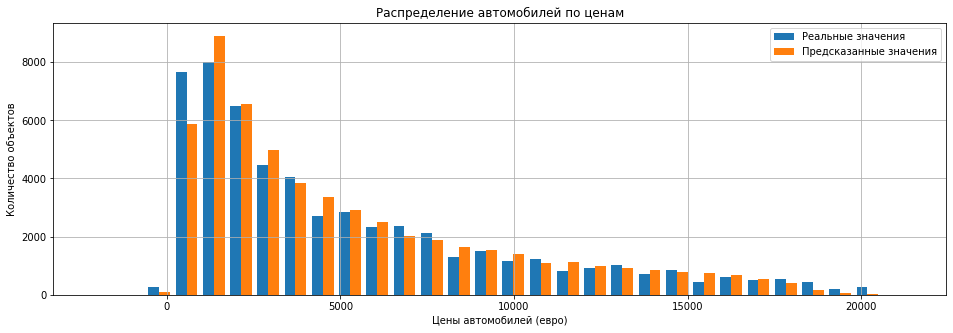

In [70]:
# lightgbm
print_info(target_test, predicted_test1)

**CatBoost**

In [71]:
model2 = CatBoostRegressor(loss_function='MAE',
                           eval_metric='RMSE',
                           cat_features=cat_features,
                           n_estimators=1000,
                           depth=5)

In [72]:
%%time
model2.fit(features_train, target_train, cat_features=cat_features, verbose=250)

0:	learn: 4902.9053442	total: 224ms	remaining: 3m 43s
250:	learn: 1845.3608766	total: 1m	remaining: 3m
500:	learn: 1755.7956269	total: 2m 3s	remaining: 2m 2s
750:	learn: 1710.7569669	total: 3m 5s	remaining: 1m 1s
999:	learn: 1684.7808371	total: 4m 6s	remaining: 0us
CPU times: user 3min 38s, sys: 27.7 s, total: 4min 6s
Wall time: 4min 8s


In [73]:
%%time
predicted_test2 = model2.predict(features_test)

CPU times: user 193 ms, sys: 30.1 ms, total: 223 ms
Wall time: 142 ms


RMSE модели: 1678.4179806152265
MAE: 1033.7909627092304
R2-score: 0.8731754989660726


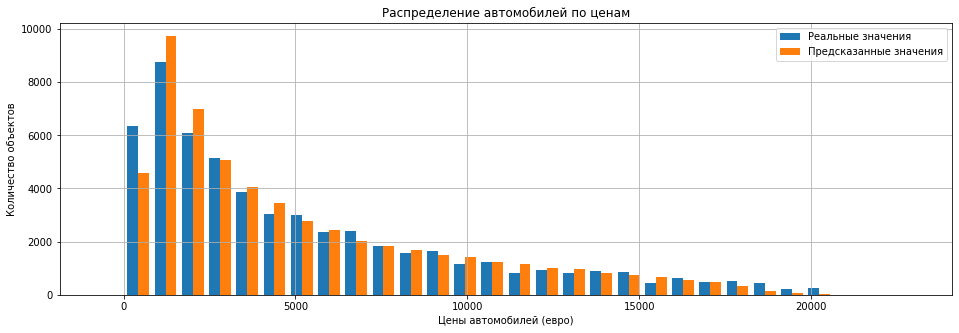

In [74]:
# catboost
print_info(target_test, predicted_test2)

**Random Forest**

In [75]:
model3 = RandomForestRegressor(
                    random_state=12345, 
                    n_estimators=200, 
                    max_depth=5, 
                    min_samples_split=2,
                    min_samples_leaf=1)

In [76]:
%%time
model3.fit(rf_features_train, rf_target_train)

CPU times: user 3min 17s, sys: 0 ns, total: 3min 17s
Wall time: 3min 18s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [77]:
%%time
predicted_test3 = model3.predict(rf_features_test)

CPU times: user 451 ms, sys: 0 ns, total: 451 ms
Wall time: 449 ms


RMSE модели: 2329.7237579236676
MAE: 1620.9746976765525
R2-score: 0.7556503211314654


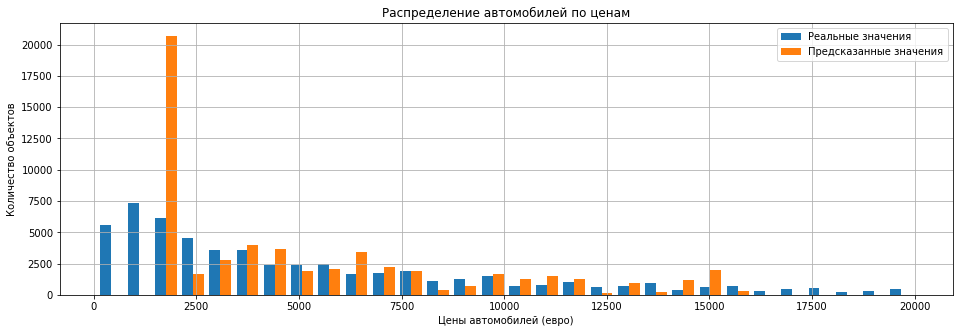

In [78]:
# random forest
print_info(rf_target_test, predicted_test3)

Сведем полученные результаты в таблицу.

In [79]:
final = np.array([[30.3, 248, 198],
                 [8.17, 0.223, 0.45],
                 [1547, 1678, 2330],
                 [976, 1034, 1621],
                 [0.8922, 0.8732, 0.7557]])
index = ['Время обучения (сек)', 'Время предсказания (сек)', 'RMSE', 'MAE', 'R2-score']
columns = ['LightGBM', 'CatBoost', 'RandomForest']
final_df = pd.DataFrame(data=final, index=index, columns=columns)
final_df.T

,Время обучения (сек),Время предсказания (сек),RMSE,MAE,R2-score
LightGBM,30.3,8.170,1547.0,976.0,0.8922
CatBoost,248.0,0.223,1678.0,1034.0,0.8732
RandomForest,198.0,0.450,2330.0,1621.0,0.7557


**Вывод**

Напомним, что заказчику важны: качество предсказания, скорость предсказания, время обучения. 

1. Качество предсказания

По этому показателю, самой лучшей оказалась модель LightGBM с показателем **RMSE = 1547**, немного хуже - CatBoost (**RMSE = 1678**). Данные показатели можно улучшить путем подбора большего числа гиперпараметров, но это в свою очередь потребует дополнительного значительного временного ресурса.

2. Время обучения

По времени обучения модель LightGBM безоговорочный фаворит. Ее показатель в более чем 6 раз лучше показателя RandomForest и в 8 раз - CatBoost.

3. Время предсказания

А вот по этому показателю наблюдаем противоположную картину. CatBoost быстрее всех предсказывает значения, показатель этой модели в 37 раз лучше показателя LightGBM.

Подводя итог, отметим следующее: в практической деятельности главными показателями являются точность и время предсказания. Обучение моделей хотя и является периодическим процессом, но не таким частым, как предсказание. Следовательно, можем заключить, что самым рациональным будет подбор гиперпараметров модели CatBoost, увеличение числа n_estimators при ее обучение и, как следствие, улучшение метрики RMSE.